In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.sod import SOD
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.lmdd import LMDD
from pyod.models.hbos import HBOS
from pyod.models.rod import ROD
from pyod.models.cof import COF

from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.mad import MAD
from pyod.models.sos import SOS
from pyod.models.qmcd import QMCD
from pyod.models.kde import KDE
from pyod.models.sampling import Sampling
from pyod.models.gmm import GMM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.rgraph import RGraph

from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.mad import MAD
from pyod.models.sos import SOS
from pyod.models.qmcd import QMCD
from pyod.models.kde import KDE
from pyod.models.sampling import Sampling
from pyod.models.gmm import GMM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.xgbod import XGBOD
from pyod.models.loda import LODA
from pyod.models.inne import INNE
from pyod.models.suod import SUOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.iforest import IForest

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
df_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

### 3 year test data.

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

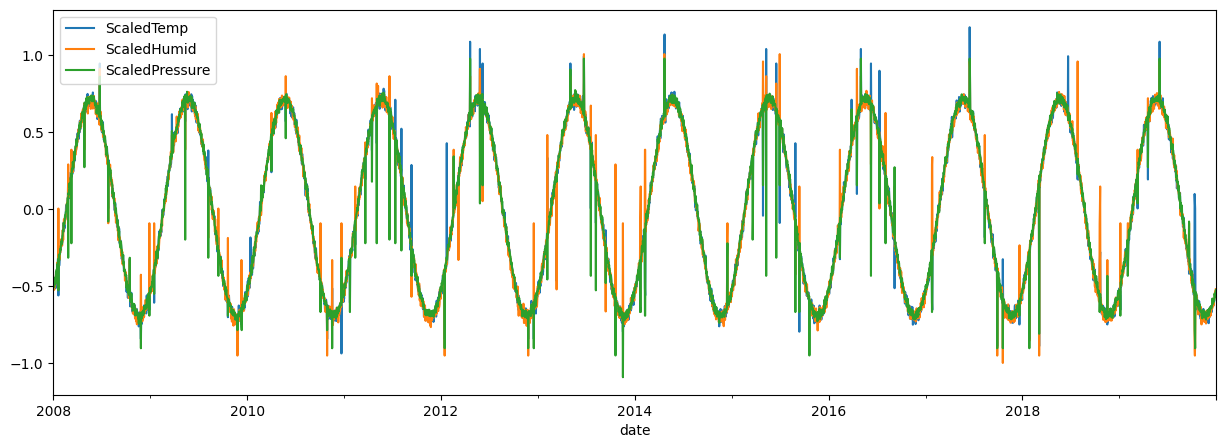

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

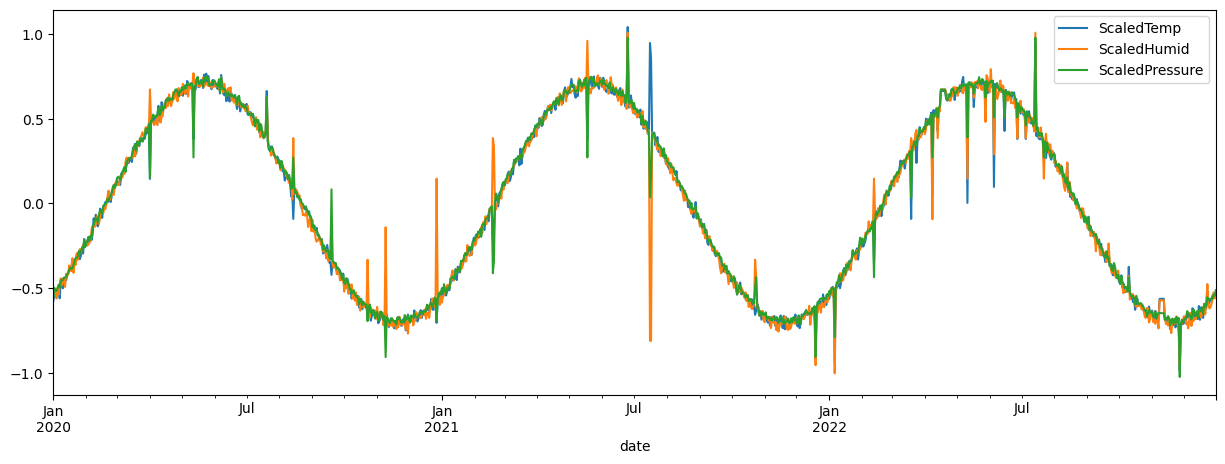

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [7]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [8]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [9]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [10]:
df_combined = df_combined.dropna()

In [11]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [12]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [13]:
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [14]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [15]:
gbr = GradientBoostingRegressor()
#n_estimators=100, learning_rate=0.05

In [16]:
models = []
for i in range(3):
    model = gbr
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [17]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))

In [18]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [19]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [20]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

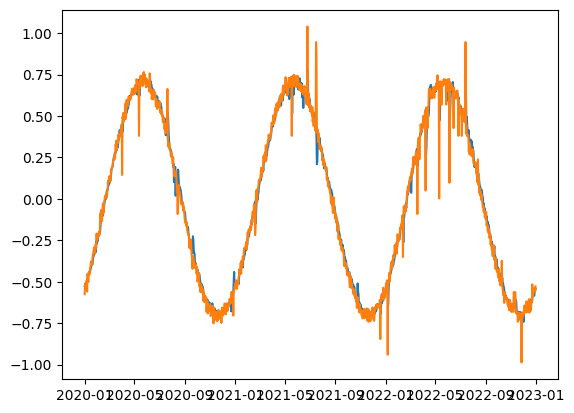

In [21]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [22]:
#test_data(predicted+actual)
data_temp_test = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_test = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_test = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [23]:
nest_samples=1096
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

In [24]:
data_kNN_test.shape

(1096, 6)

### Proximity-Based algorithms

In [25]:
# neighbour based
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_test)[:,1]

In [26]:
#local-density based
classifier_name = 'LOF'

model_lof = LOF()

# Prediction on training data
model_lof.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_lof = model_lof.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_lof_scores = model_lof.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_lof = model_lof.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_lof_scores = model_lof.predict_proba(data_kNN_test)[:,1]

In [27]:
#CBLOF--clustering based algorithm

classifier_name = 'CBLOF'

model_cblof = CBLOF()

# Prediction on training data
model_cblof.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_cblof = model_cblof.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_cblof_scores = model_cblof.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_cblof = model_cblof.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_cblof_scores = model_cblof.predict_proba(data_kNN_test)[:,1]

In [28]:
#HBOS

classifier_name = 'HBOS'

model_hbos = HBOS()

# Prediction on training data
model_hbos.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_hbos = model_hbos.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_hbos_scores = model_hbos.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_hbos = model_hbos.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_hbos_scores = model_hbos.predict_proba(data_kNN_test)[:,1]

In [29]:
#ROD

classifier_name = 'ROD'

model_rod = ROD()

# Prediction on training data
model_rod.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_rod = model_rod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_rod_scores = model_rod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_rod = model_rod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_rod_scores = model_rod.predict_proba(data_kNN_test)[:,1]

In [30]:
#COF

classifier_name = 'COF'

model_cof = COF()

# Prediction on training data
model_cof.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_cof = model_cof.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_cof_scores = model_cof.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_cof = model_cof.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_cof_scores = model_cof.predict_proba(data_kNN_test)[:,1]

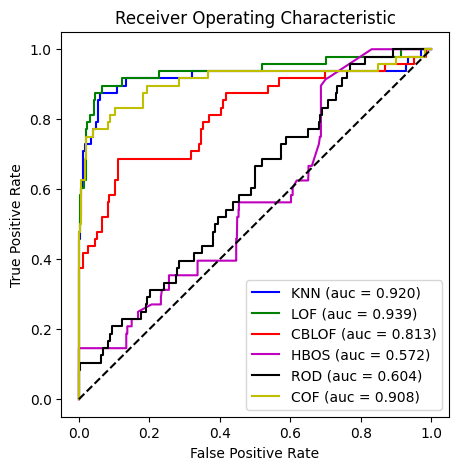

In [31]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_lof_scores)
fpr_lof, tpr_lof, thresholds_lof = roc_curve(ground_truth_test, test_prediction_lof_scores)
auc_lof = auc(fpr_lof,tpr_lof)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_cblof_scores)
fpr_cblof, tpr_cblof, thresholds_cblof = roc_curve(ground_truth_test, test_prediction_cblof_scores)
auc_cblof = auc(fpr_cblof,tpr_cblof)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_hbos_scores)
fpr_hbos, tpr_hbos, thresholds_hbos = roc_curve(ground_truth_test, test_prediction_hbos_scores)
auc_hbos = auc(fpr_hbos,tpr_hbos)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_rod_scores)
fpr_rod, tpr_rod, thresholds_rod = roc_curve(ground_truth_test, test_prediction_rod_scores)
auc_rod = auc(fpr_rod,tpr_rod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_cof_scores)
fpr_cof, tpr_cof, thresholds_cof = roc_curve(ground_truth_test, test_prediction_cof_scores)
auc_cof = auc(fpr_cof,tpr_cof)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', color='b', label='KNN (auc = %0.3f)' % auc_kNN)

plt.plot(fpr_lof, tpr_lof, linestyle='-', color='g', label='LOF (auc = %0.3f)' % auc_lof)

plt.plot(fpr_cblof, tpr_cblof, linestyle='-', color='r', label='CBLOF (auc = %0.3f)' % auc_cblof)

plt.plot(fpr_hbos, tpr_hbos, linestyle='-', color='m', label='HBOS (auc = %0.3f)' % auc_hbos)

plt.plot(fpr_rod, tpr_rod, linestyle='-', color='k', label='ROD (auc = %0.3f)' % auc_rod)

plt.plot(fpr_cof, tpr_cof, linestyle='-', color='y', label='COF (auc = %0.3f)' % auc_cof)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [32]:
#knn,lof and cof performed better

### Linear Model

In [33]:
#PCA

classifier_name = 'PCA'

model_pca = PCA()

# Prediction on training data
model_pca.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_pca = model_pca.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_pca_scores = model_pca.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_pca = model_pca.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_pca_scores = model_pca.predict_proba(data_kNN_test)[:,1]

In [34]:
#KPCA

classifier_name = 'KPCA'

model_kpca = KPCA(kernel='rbf')

# Prediction on training data
model_kpca.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_kpca = model_kpca.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_kpca_scores = model_kpca.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_kpca = model_kpca.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_kpca_scores = model_kpca.predict_proba(data_kNN_test)[:,1]

In [35]:
#MCD

classifier_name = 'MCD'

model_mcd = MCD()

# Prediction on training data
model_mcd.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_mcd = model_mcd.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_mcd_scores = model_mcd.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_mcd = model_mcd.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_mcd_scores = model_mcd.predict_proba(data_kNN_test)[:,1]

In [36]:
#OCSVM

classifier_name = 'OCSVM'

model_ocsvm = OCSVM()

# Prediction on training data
model_ocsvm.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_ocsvm = model_ocsvm.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_ocsvm_scores = model_ocsvm.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_ocsvm = model_ocsvm.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_ocsvm_scores = model_ocsvm.predict_proba(data_kNN_test)[:,1]

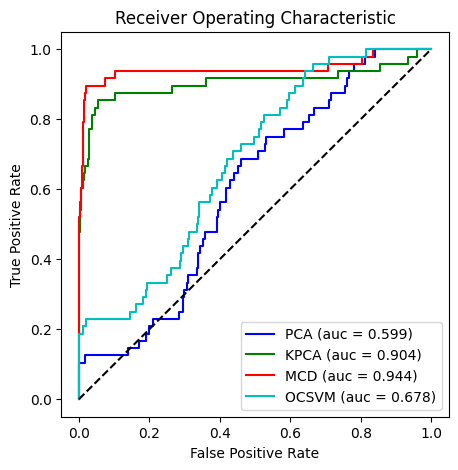

In [37]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_pca_scores)
fpr_pca, tpr_pca, thresholds_pca = roc_curve(ground_truth_test, test_prediction_pca_scores)
auc_pca = auc(fpr_pca,tpr_pca)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_kpca_scores)
fpr_kpca, tpr_kpca, thresholds_kpca = roc_curve(ground_truth_test, test_prediction_kpca_scores)
auc_kpca = auc(fpr_kpca,tpr_kpca)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_mcd_scores)
fpr_mcd, tpr_mcd, thresholds_mcd = roc_curve(ground_truth_test, test_prediction_mcd_scores)
auc_mcd = auc(fpr_mcd,tpr_mcd)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_ocsvm_scores)
fpr_ocsvm, tpr_ocsvm, thresholds_ocsvm = roc_curve(ground_truth_test, test_prediction_ocsvm_scores)
auc_ocsvm = auc(fpr_ocsvm,tpr_ocsvm)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_pca, tpr_pca, linestyle='-', color='b', label='PCA (auc = %0.3f)' % auc_pca)

plt.plot(fpr_kpca, tpr_kpca, linestyle='-', color='g', label='KPCA (auc = %0.3f)' % auc_kpca)

plt.plot(fpr_mcd, tpr_mcd, linestyle='-', color='r', label='MCD (auc = %0.3f)' % auc_mcd)

plt.plot(fpr_ocsvm, tpr_ocsvm, linestyle='-', color='c', label='OCSVM (auc = %0.3f)' % auc_ocsvm)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [38]:
#MCD and KPCA performed well.

### Probabilistic

In [39]:
#ECOD

classifier_name = 'ECOD'

model_ecod = ECOD()

# Prediction on training data
model_ecod.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_ecod = model_ecod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_ecod_scores = model_ecod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_ecod = model_ecod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_ecod_scores = model_ecod.predict_proba(data_kNN_test)[:,1]

In [40]:
#COPOD

classifier_name = 'COPOD'

model_copod = COPOD()

# Prediction on training data
model_copod.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_copod = model_copod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_copod_scores = model_copod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_copod = model_copod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_copod_scores = model_copod.predict_proba(data_kNN_test)[:,1]

In [41]:
#ABOD

classifier_name = 'ABOD'

model_abod = ABOD()

# Prediction on training data
model_abod.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_abod = model_abod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_abod_scores = model_abod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_abod = model_abod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_abod_scores = model_abod.predict_proba(data_kNN_test)[:,1]

In [42]:
#MAD is for univariate data only.

#SOS

classifier_name = 'SOS'

model_sos = SOS()

# Prediction on training data
model_sos.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_sos = model_sos.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_sos_scores = model_sos.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_sos = model_sos.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_sos_scores = model_sos.predict_proba(data_kNN_test)[:,1]

In [43]:
#QMCD

classifier_name = 'QMCD'

model_qmcd = QMCD()

# Prediction on training data
model_qmcd.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_qmcd = model_qmcd.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_qmcd_scores = model_qmcd.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_qmcd = model_qmcd.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_qmcd_scores = model_qmcd.predict_proba(data_kNN_test)[:,1]

In [44]:
#KDE

classifier_name = 'KDE'

model_kde = KDE()

# Prediction on training data
model_kde.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_kde = model_kde.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_kde_scores = model_kde.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_kde = model_kde.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_kde_scores = model_kde.predict_proba(data_kNN_test)[:,1]

In [45]:
#Sampling

classifier_name = 'SAMPLING'

model_sampling = Sampling()

# Prediction on training data
model_sampling.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_sampling = model_sampling.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_sampling_scores = model_sampling.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_sampling = model_sampling.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_sampling_scores = model_sampling.predict_proba(data_kNN_test)[:,1]

In [46]:
#GMM

classifier_name = 'GMM'

model_gmm = GMM()

# Prediction on training data
model_gmm.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_gmm = model_gmm.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_gmm_scores = model_gmm.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_gmm = model_gmm.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_gmm_scores = model_gmm.predict_proba(data_kNN_test)[:,1]

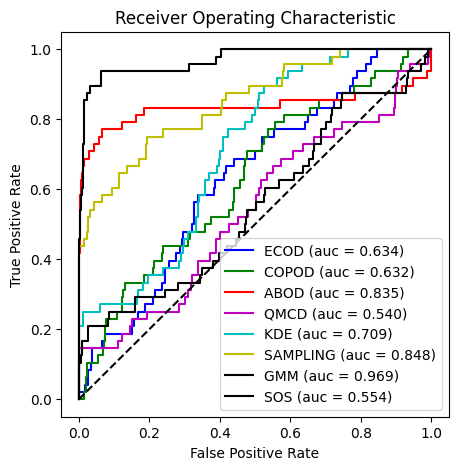

In [47]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_ecod_scores)
fpr_ecod, tpr_ecod, thresholds_ecod = roc_curve(ground_truth_test, test_prediction_ecod_scores)
auc_ecod = auc(fpr_ecod,tpr_ecod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_copod_scores)
fpr_copod, tpr_copod, thresholds_copod = roc_curve(ground_truth_test, test_prediction_copod_scores)
auc_copod = auc(fpr_copod,tpr_copod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_abod_scores)
fpr_abod, tpr_abod, thresholds_abod = roc_curve(ground_truth_test, test_prediction_abod_scores)
auc_abod = auc(fpr_abod,tpr_abod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_sos_scores)
fpr_sos, tpr_sos, thresholds_sos = roc_curve(ground_truth_test, test_prediction_sos_scores)
auc_sos = auc(fpr_sos,tpr_sos)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_qmcd_scores)
fpr_qmcd, tpr_qmcd, thresholds_qmcd = roc_curve(ground_truth_test, test_prediction_qmcd_scores)
auc_qmcd = auc(fpr_qmcd,tpr_qmcd)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_kde_scores)
fpr_kde, tpr_kde, thresholds_kde = roc_curve(ground_truth_test, test_prediction_kde_scores)
auc_kde = auc(fpr_kde,tpr_kde)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_sampling_scores)
fpr_sampling, tpr_sampling, thresholds_sampling = roc_curve(ground_truth_test, test_prediction_sampling_scores)
auc_sampling = auc(fpr_sampling,tpr_sampling)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_gmm_scores)
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(ground_truth_test, test_prediction_gmm_scores)
auc_gmm = auc(fpr_gmm,tpr_gmm)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_ecod, tpr_ecod, linestyle='-', color='b', label='ECOD (auc = %0.3f)' % auc_ecod)

plt.plot(fpr_copod, tpr_copod, linestyle='-', color='g', label='COPOD (auc = %0.3f)' % auc_copod)

plt.plot(fpr_abod, tpr_abod, linestyle='-', color='r', label='ABOD (auc = %0.3f)' % auc_abod)

plt.plot(fpr_qmcd, tpr_qmcd, linestyle='-', color='m', label='QMCD (auc = %0.3f)' % auc_qmcd)

plt.plot(fpr_kde, tpr_kde, linestyle='-', color='c', label='KDE (auc = %0.3f)' % auc_kde)

plt.plot(fpr_sampling, tpr_sampling, linestyle='-', color='y', label='SAMPLING (auc = %0.3f)' % auc_sampling)

plt.plot(fpr_gmm, tpr_gmm, linestyle='-', color='k', label='GMM (auc = %0.3f)' % auc_gmm)

plt.plot(fpr_sos, tpr_sos, linestyle='-', color='k', label='SOS (auc = %0.3f)' % auc_sos)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [48]:
# GMM and ABOD works better. Next sampling.

### Neural Net

In [49]:
#AutoEncoder

classifier_name = 'AutoEncoder'

model_autoencoder = AutoEncoder(hidden_neurons=[6,64,64,6])

# Prediction on training data
model_autoencoder.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_autoencoder = model_autoencoder.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_autoencoder_scores = model_autoencoder.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_autoencoder = model_autoencoder.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_autoencoder_scores = model_autoencoder.predict_proba(data_kNN_test)[:,1]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dropout_2 (Dropout)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [50]:
#DeepSVDD

classifier_name = 'DeepSVDD'

model_deepsvdd = DeepSVDD(hidden_neurons=[6,64,64,6])

# Prediction on training data
model_deepsvdd.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_deepsvdd = model_deepsvdd.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_deepsvdd_scores = model_deepsvdd.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_deepsvdd = model_deepsvdd.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_deepsvdd_scores = model_deepsvdd.predict_proba(data_kNN_test)[:,1]

35/35 [==============================] - 0s 2ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_10 (Dense)            (None, 6)                 36        
                                                                 
 dense_11 (Dense)            (None, 64)                384       
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4096      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 net_o

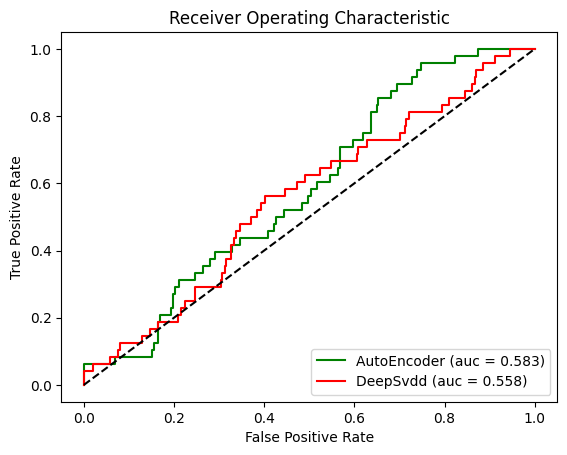

In [51]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_autoencoder_scores)
fpr_autoencoder, tpr_autoencoder, thresholds_autoencoder = roc_curve(ground_truth_test, test_prediction_autoencoder_scores)
auc_autoencoder = auc(fpr_autoencoder,tpr_autoencoder)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_deepsvdd_scores)
fpr_deepsvdd, tpr_deepsvdd, thresholds_deepsvdd = roc_curve(ground_truth_test, test_prediction_deepsvdd_scores)
auc_deepsvdd = auc(fpr_deepsvdd,tpr_deepsvdd)

plt.plot(fpr_autoencoder, tpr_autoencoder, linestyle='-', color='g', label='AutoEncoder (auc = %0.3f)' % auc_autoencoder)

plt.plot(fpr_deepsvdd, tpr_deepsvdd, linestyle='-', color='r', label='DeepSvdd (auc = %0.3f)' % auc_deepsvdd)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Outlier Ensembles

In [52]:
#XGBOD----->supervised--to do

In [53]:
#LODA
classifier_name = 'LODA'

model_loda = LODA()

# Prediction on training data
model_loda.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_loda = model_loda.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_loda_scores = model_loda.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_loda = model_loda.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_loda_scores = model_loda.predict_proba(data_kNN_test)[:,1]

In [54]:
#INNE
classifier_name = 'INNE'

model_inne = INNE()

# Prediction on training data
model_inne.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_inne = model_inne.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_inne_scores = model_inne.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_inne = model_inne.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_inne_scores = model_inne.predict_proba(data_kNN_test)[:,1]

In [55]:
#SUOD
classifier_name = 'SUOD'

model_suod = SUOD()

# Prediction on training data
model_suod.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_suod = model_suod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_suod_scores = model_suod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_suod = model_suod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_suod_scores = model_suod.predict_proba(data_kNN_test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [56]:
#FeatureBagging
classifier_name = 'FeatureBagging'

model_FeatureBagging = FeatureBagging()

# Prediction on training data
model_FeatureBagging.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_FeatureBagging = model_FeatureBagging.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_FeatureBagging_scores = model_FeatureBagging.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_FeatureBagging = model_FeatureBagging.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_FeatureBagging_scores = model_FeatureBagging.predict_proba(data_kNN_test)[:,1]

In [57]:
#IForest
classifier_name = 'IForest'

model_IForest = IForest()

# Prediction on training data
model_IForest.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction_IForest = model_IForest.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_IForest_scores = model_IForest.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_IForest = model_IForest.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_IForest_scores = model_IForest.predict_proba(data_kNN_test)[:,1]

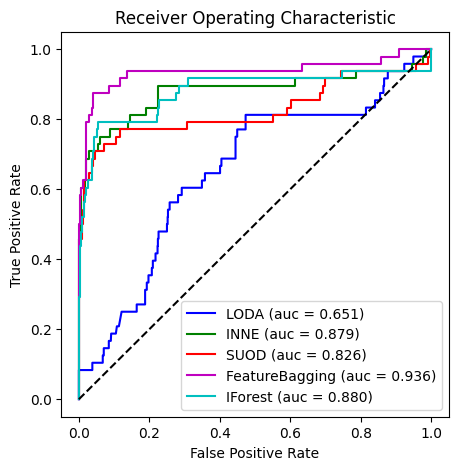

In [58]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_loda_scores)
fpr_loda, tpr_loda, thresholds_loda = roc_curve(ground_truth_test, test_prediction_loda_scores)
auc_loda = auc(fpr_loda,tpr_loda)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_inne_scores)
fpr_inne, tpr_inne, thresholds_inne = roc_curve(ground_truth_test, test_prediction_inne_scores)
auc_inne = auc(fpr_inne,tpr_inne)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_suod_scores)
fpr_suod, tpr_suod, thresholds_suod = roc_curve(ground_truth_test, test_prediction_suod_scores)
auc_suod = auc(fpr_suod,tpr_suod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_FeatureBagging_scores)
fpr_FeatureBagging, tpr_FeatureBagging, thresholds_FeatureBagging = roc_curve(ground_truth_test, test_prediction_FeatureBagging_scores)
auc_FeatureBagging = auc(fpr_FeatureBagging,tpr_FeatureBagging)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_IForest_scores)
fpr_IForest, tpr_IForest, thresholds_IForest = roc_curve(ground_truth_test, test_prediction_IForest_scores)
auc_IForest = auc(fpr_IForest,tpr_IForest)



plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_loda, tpr_loda, linestyle='-', color='b', label='LODA (auc = %0.3f)' % auc_loda)

plt.plot(fpr_inne, tpr_inne, linestyle='-', color='g', label='INNE (auc = %0.3f)' % auc_inne)

plt.plot(fpr_suod, tpr_suod, linestyle='-', color='r', label='SUOD (auc = %0.3f)' % auc_suod)

plt.plot(fpr_FeatureBagging, tpr_FeatureBagging, linestyle='-', color='m', label='FeatureBagging (auc = %0.3f)' % auc_FeatureBagging)

plt.plot(fpr_IForest, tpr_IForest, linestyle='-', color='c', label='IForest (auc = %0.3f)' % auc_IForest)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [59]:
# IForest, featurebagging,INNE worked best.

### Comparision between techniques

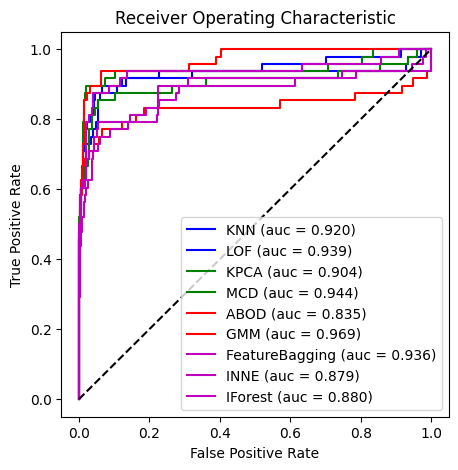

In [60]:
#Proximity-based algorithms(kNN and LoF)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_lof_scores)
fpr_lof, tpr_lof, thresholds_lof = roc_curve(ground_truth_test, test_prediction_lof_scores)
auc_lof = auc(fpr_lof,tpr_lof)

#Linear Model(KPCA and MCD)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_kpca_scores)
fpr_kpca, tpr_kpca, thresholds_kpca = roc_curve(ground_truth_test, test_prediction_kpca_scores)
auc_kpca = auc(fpr_kpca,tpr_kpca)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_mcd_scores)
fpr_mcd, tpr_mcd, thresholds_mcd = roc_curve(ground_truth_test, test_prediction_mcd_scores)
auc_mcd = auc(fpr_mcd,tpr_mcd)


#Probabilistic Model(ABOD and GMM)
auc_roc = roc_auc_score(ground_truth_test, test_prediction_abod_scores)
fpr_abod, tpr_abod, thresholds_abod = roc_curve(ground_truth_test, test_prediction_abod_scores)
auc_abod = auc(fpr_abod,tpr_abod)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_gmm_scores)
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(ground_truth_test, test_prediction_gmm_scores)
auc_gmm = auc(fpr_gmm,tpr_gmm)

#Ensembels Method
auc_roc = roc_auc_score(ground_truth_test, test_prediction_inne_scores)
fpr_inne, tpr_inne, thresholds_inne = roc_curve(ground_truth_test, test_prediction_inne_scores)
auc_inne = auc(fpr_inne,tpr_inne)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_FeatureBagging_scores)
fpr_FeatureBagging, tpr_FeatureBagging, thresholds_FeatureBagging = roc_curve(ground_truth_test, test_prediction_FeatureBagging_scores)
auc_FeatureBagging = auc(fpr_FeatureBagging,tpr_FeatureBagging)

auc_roc = roc_auc_score(ground_truth_test, test_prediction_IForest_scores)
fpr_IForest, tpr_IForest, thresholds_IForest = roc_curve(ground_truth_test, test_prediction_IForest_scores)
auc_IForest = auc(fpr_IForest,tpr_IForest)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', color='b', label='KNN (auc = %0.3f)' % auc_kNN)

plt.plot(fpr_lof, tpr_lof, linestyle='-', color='b', label='LOF (auc = %0.3f)' % auc_lof)

plt.plot(fpr_kpca, tpr_kpca, linestyle='-', color='g', label='KPCA (auc = %0.3f)' % auc_kpca)

plt.plot(fpr_mcd, tpr_mcd, linestyle='-', color='g', label='MCD (auc = %0.3f)' % auc_mcd)

plt.plot(fpr_abod, tpr_abod, linestyle='-', color='r', label='ABOD (auc = %0.3f)' % auc_abod)

plt.plot(fpr_gmm, tpr_gmm, linestyle='-', color='r', label='GMM (auc = %0.3f)' % auc_gmm)

plt.plot(fpr_FeatureBagging, tpr_FeatureBagging, linestyle='-', color='m', label='FeatureBagging (auc = %0.3f)' % auc_FeatureBagging)

plt.plot(fpr_inne, tpr_inne, linestyle='-', color='m', label='INNE (auc = %0.3f)' % auc_inne)

plt.plot(fpr_IForest, tpr_IForest, linestyle='-', color='m', label='IForest (auc = %0.3f)' % auc_IForest)

plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [61]:
# ABOD,INNE and IForest does not work that well. Featurebagging works well.

In [62]:
#Supervised not possible as trivial solution

[04:17:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



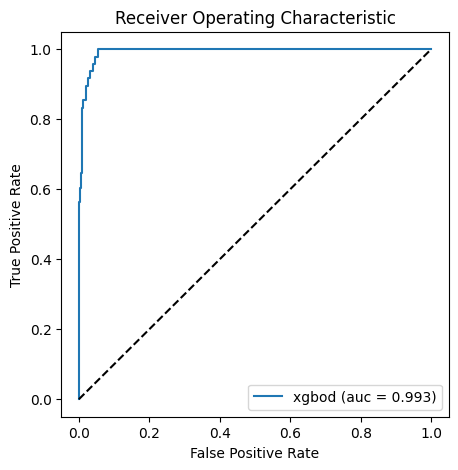


On Training Data:
XGBOD ROC:1.0, precision @ rank n:1.0

On Test Data:
XGBOD ROC:0.9928, precision @ rank n:0.7917

Outlier prediction information on Test Data: 1096 {0: 1048, 1: 48}
No of Errors in test set: 20

RMS on Test Set : 0.1350858067395748

MAE on Test Set : 0.01824817518248175


array([[1038,   10],
       [  10,   38]], dtype=int64)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.xgbod import XGBOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'XGBOD'
model_xgbod = XGBOD()

# Prediction on training data
model_xgbod.fit(data_kNN_test, ground_truth_test)  # y is ignored in unsupervised setting.
train_prediction = model_xgbod.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_xgbod.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_xgbod.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_xgbod.predict_proba(data_kNN_test)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_xgbod = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='xgbod (auc = %0.3f)' % auc_xgbod)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print statement
print("\nOn Training Data:")
evaluate_print(classifier_name, ground_truth_test, train_prediction_scores)
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_xgbod.predict(data_kNN_test))